If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

# Installation
To be able to run the animation below, make sure you have the latest version of matplotlib, by running `pip3 install matplotlib --upgrade`

In [2]:
%matplotlib inline
import json
import numpy as np
import random
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Define the game environment and replay classes

In [3]:
class Catch(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_basket_center = 1
        self.max_basket_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves basket according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, basket_center = self.state
        # move the basket unless this would move it off the edge of the grid
        new_basket_center = min(max(self.min_basket_center, basket_center + movement), self.max_basket_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_basket_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and basket and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, basket_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, basket_center-1:basket_center + 2] = 1  # draw 3-pixel basket
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was caught, -1 if it was dropped, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, basket_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - basket_center) <= 1:
                return 1 # it caught the fruit
            else:
                return -1 # it dropped the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if game is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        game_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, game_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            basket center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        basket_center = random.randint(self.min_basket_center, self.max_basket_center)
        self.state = np.asarray([fruit_x, fruit_y, basket_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            game_over: boolean
        Add the states and game over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            game_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i:i+1] = starting_observation
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if game_over: 
                # if the game is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the game is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




## Creating Snake Enviorment

In [8]:
class Snake(object):
    def __init__(self, grid_size = 45, max_moves_multiplyer = 1):
        self.max_moves = (grid_size**2) *  max_moves_multiplyer
        self.grid_size = grid_size
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]
    
    def _update_state(self, action):
        [fruit_x, fruit_y], snake, [move] = self.state
        
        direction = [snake[0][0] - snake[1][0], snake[0][1] - snake[1][1]]
        if action == 0:
            movement = direction # Forward
        elif action == 1:
            movement = [-1*direction[1], direction[0]] # Right
        elif action == 2:
            movement = [direction[1], -1*direction[0]] # Down
        else:
            raise Exception('Invalid action {}'.format(action))
        
        snake_new = [np.add(snake[0], movement).tolist()] + snake
        
        if [fruit_x, fruit_y] not in snake_new:
            snake_new = snake_new[:-1]
        
        #print("Snake: {}".format(snake))
        self.state = [[fruit_x, fruit_y], snake_new, [move + 1]]
        
    def _draw_state(self):
        
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        [fruit_x, fruit_y], snake, [move] = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        for coord in snake:
            try:
                canvas[coord[1]][coord[0]] = 1  # draw snake
            except IndexError:
                canvas = np.zeros(im_size)
                #print('dead')
                break
        return canvas
        
    def _get_reward(self):
        
        [fruit_x, fruit_y], snake, [move] = self.state
        if snake[0] in snake[1:]:
            #print("ouch")
            return -1 # it hit itself
        if snake[0][0] < 0 or snake[0][0] > self.grid_size - 1 or snake[0][1] < 0 or snake[0][1] > self.grid_size - 1:
            return -1 # it hit a wall
        if [fruit_x, fruit_y] in snake:
            #print("got fruit?")
            while [fruit_x, fruit_y] in snake: # reseting fruit probably, need a better way if the snake gets good.
                fruit_x = np.random.randint(0, grid_size)
                fruit_y = np.random.randint(0, grid_size)
            self.state[0] = [fruit_x, fruit_y]
            self.state[2] = [0]
            return 1 # it ate the fruit
        if move > (self.max_moves) + (len(snake)):
            return -1 # ran out of time
#         if (fruit_x - snake[0][0])**2 + (fruit_y - snake[0][1])**2 < (fruit_x - snake[1][0])**2 + (fruit_y - snake[1][1])**2:
#             return 1
        else:
            return 0 # the fruit is still on the board
    
    def observe(self):
        
        canvas = self._draw_state()
        return canvas.reshape((1, -1))
    
    def act(self, action):
        
        self._update_state(action)
        reward = self._get_reward()
        if reward != -1:
            observation = self.observe()
        else:
            [fruit_x, fruit_y], snake, [move] = self.state
            self.state = [[fruit_x, fruit_y], snake[1:], [move]] # removing head bc if it goes out of bounds then the observe does not work.
            observation = self.observe()
        
        game_over = (reward < 0) # if the reward is -1 then the snake died
        return observation, reward, game_over
    
    def reset(self):
        
        snake = [[int(grid_size/2), int(grid_size/2)]]
        snake.append([snake[0][0] - 1, snake[0][1]])
        fruit_x = np.random.randint(0, grid_size)
        fruit_y = np.random.randint(0, grid_size)
#         fruit_x = snake[0][0] + 1
#         fruit_y = snake[0][1]
        move = 0
        self.state = [[fruit_x, fruit_y], snake, [move]]

##  Functions for creating, training, and visualizing the model

In [5]:
# parameters
epsilon = .2  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.2), "mse")

    # Define environment/game
    env = Snake(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay


def train_model(model, env, exp_replay, num_episodes):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    
    for episode in range(num_episodes):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        starting_observation = env.observe()
        
        catch_count = 0

        while not game_over:
            # get next action
            if np.random.rand() <= epsilon:
                # epsilon of the time, we just choose randomly
                action = np.random.randint(0, num_actions, size=1)
            else:
                # find which action the model currently thinks is best from this state
                q = model.predict(starting_observation)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            new_observation, reward, game_over = env.act(action)
            if reward == 2:
                catch_count += 1

            # store experience
            exp_replay.remember([starting_observation, action, reward, new_observation], game_over)

            # get data updated based on the stored experiences
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            # train model on the updated data
            loss += model.train_on_batch(inputs, targets)

            starting_observation = new_observation # for next time through the loop

        # Print update from this episode
        print("Episode {:04d}/{:04d} | Loss {:.4f} | Catch count {} ".format(episode, num_episodes-1, loss, catch_count))


def create_animation(model, env, num_games):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_games: integer, the number of games to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the games and collect all of the images for each observed state
    
    observations = []
    for _ in range(num_games):
        print("game start")
        env.reset()
        observation = env.observe()
        observations.append(observation)
        game_over = False
        while game_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
#             action = np.random.randint(0,4)
#             action = 1
            # apply action, get rewards and new state
            observation, reward, game_over = env.act(action)
            observations.append(observation)
            #print("move")
            print(reward)
        print("game end")
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Let's create our model and game environment and see how it does before training

In [55]:
model, env, exp_replay = build_model()

game start
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
-1
game end
game start
1
0
0
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
-1
game end
game start
0
0
0
1
0
0
1
1
1
0
0
1
0
0
0
0
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
-1
game end


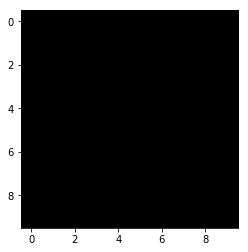

In [52]:
animation = create_animation(model, env, num_games=3)
IPython.display.HTML(animation.to_jshtml())

## Now train the model and see how much better it is at catching the fruit

Episode 0000/0999 | Loss 7.2758 | Catch count 0 
Episode 0001/0999 | Loss 13.5438 | Catch count 0 
Episode 0002/0999 | Loss 10.0873 | Catch count 0 
Episode 0003/0999 | Loss 15.2221 | Catch count 0 
Episode 0004/0999 | Loss 5.3086 | Catch count 1 
Episode 0005/0999 | Loss 3.5809 | Catch count 0 
Episode 0006/0999 | Loss 4.0910 | Catch count 0 
Episode 0007/0999 | Loss 9.0765 | Catch count 1 
Episode 0008/0999 | Loss 9.5614 | Catch count 0 
Episode 0009/0999 | Loss 1.2664 | Catch count 0 
Episode 0010/0999 | Loss 21.8427 | Catch count 1 
Episode 0011/0999 | Loss 2.7557 | Catch count 0 
Episode 0012/0999 | Loss 4.2735 | Catch count 0 
Episode 0013/0999 | Loss 2.4792 | Catch count 0 
Episode 0014/0999 | Loss 12.1761 | Catch count 0 
Episode 0015/0999 | Loss 2.4748 | Catch count 0 
Episode 0016/0999 | Loss 11.6380 | Catch count 0 
Episode 0017/0999 | Loss 4.8682 | Catch count 0 
Episode 0018/0999 | Loss 1.2227 | Catch count 0 
Episode 0019/0999 | Loss 8.9910 | Catch count 0 
Episode 0020/0

Episode 0167/0999 | Loss 2.6975 | Catch count 0 
Episode 0168/0999 | Loss 6.9154 | Catch count 0 
Episode 0169/0999 | Loss 3.1137 | Catch count 0 
Episode 0170/0999 | Loss 3.3397 | Catch count 0 
Episode 0171/0999 | Loss 13.0750 | Catch count 1 
Episode 0172/0999 | Loss 1.8077 | Catch count 0 
Episode 0173/0999 | Loss 1.9615 | Catch count 0 
Episode 0174/0999 | Loss 2.0345 | Catch count 0 
Episode 0175/0999 | Loss 2.1662 | Catch count 0 
Episode 0176/0999 | Loss 9.1383 | Catch count 0 
Episode 0177/0999 | Loss 0.9033 | Catch count 0 
Episode 0178/0999 | Loss 3.9924 | Catch count 1 
Episode 0179/0999 | Loss 7.5344 | Catch count 1 
Episode 0180/0999 | Loss 1.8292 | Catch count 0 
Episode 0181/0999 | Loss 2.9211 | Catch count 0 
Episode 0182/0999 | Loss 3.2083 | Catch count 0 
Episode 0183/0999 | Loss 7.8769 | Catch count 2 
Episode 0184/0999 | Loss 4.8977 | Catch count 1 
Episode 0185/0999 | Loss 4.0415 | Catch count 0 
Episode 0186/0999 | Loss 4.8490 | Catch count 1 
Episode 0187/0999 |

Episode 0334/0999 | Loss 1.7831 | Catch count 0 
Episode 0335/0999 | Loss 4.4526 | Catch count 0 
Episode 0336/0999 | Loss 8.0456 | Catch count 0 
Episode 0337/0999 | Loss 7.2018 | Catch count 0 
Episode 0338/0999 | Loss 2.2935 | Catch count 0 
Episode 0339/0999 | Loss 12.8377 | Catch count 2 
Episode 0340/0999 | Loss 1.3452 | Catch count 0 
Episode 0341/0999 | Loss 1.3038 | Catch count 0 
Episode 0342/0999 | Loss 3.5785 | Catch count 0 
Episode 0343/0999 | Loss 2.9004 | Catch count 0 
Episode 0344/0999 | Loss 2.7104 | Catch count 0 
Episode 0345/0999 | Loss 2.0861 | Catch count 0 
Episode 0346/0999 | Loss 2.9630 | Catch count 1 
Episode 0347/0999 | Loss 1.3477 | Catch count 0 
Episode 0348/0999 | Loss 8.5170 | Catch count 0 
Episode 0349/0999 | Loss 19.9454 | Catch count 0 
Episode 0350/0999 | Loss 8.9885 | Catch count 0 
Episode 0351/0999 | Loss 15.1137 | Catch count 1 
Episode 0352/0999 | Loss 18.2189 | Catch count 0 
Episode 0353/0999 | Loss 4.6729 | Catch count 0 
Episode 0354/099

Episode 0501/0999 | Loss 2.5564 | Catch count 0 
Episode 0502/0999 | Loss 2.3427 | Catch count 0 
Episode 0503/0999 | Loss 10.5218 | Catch count 0 
Episode 0504/0999 | Loss 1.1872 | Catch count 1 
Episode 0505/0999 | Loss 2.7438 | Catch count 0 
Episode 0506/0999 | Loss 10.7195 | Catch count 0 
Episode 0507/0999 | Loss 1.0690 | Catch count 0 
Episode 0508/0999 | Loss 3.4185 | Catch count 0 
Episode 0509/0999 | Loss 1.1319 | Catch count 0 
Episode 0510/0999 | Loss 3.7681 | Catch count 2 
Episode 0511/0999 | Loss 1.2532 | Catch count 0 
Episode 0512/0999 | Loss 2.0382 | Catch count 0 
Episode 0513/0999 | Loss 2.4856 | Catch count 0 
Episode 0514/0999 | Loss 3.2482 | Catch count 0 
Episode 0515/0999 | Loss 2.8574 | Catch count 0 
Episode 0516/0999 | Loss 1.8900 | Catch count 0 
Episode 0517/0999 | Loss 1.6480 | Catch count 0 
Episode 0518/0999 | Loss 4.5995 | Catch count 0 
Episode 0519/0999 | Loss 4.5066 | Catch count 1 
Episode 0520/0999 | Loss 0.6408 | Catch count 0 
Episode 0521/0999 

Episode 0668/0999 | Loss 6.0750 | Catch count 2 
Episode 0669/0999 | Loss 11.6020 | Catch count 0 
Episode 0670/0999 | Loss 10.4209 | Catch count 0 
Episode 0671/0999 | Loss 4.0160 | Catch count 0 
Episode 0672/0999 | Loss 5.9986 | Catch count 0 
Episode 0673/0999 | Loss 19.3853 | Catch count 0 
Episode 0674/0999 | Loss 6.7017 | Catch count 1 
Episode 0675/0999 | Loss 1.1542 | Catch count 0 
Episode 0676/0999 | Loss 3.9790 | Catch count 0 
Episode 0677/0999 | Loss 4.5519 | Catch count 0 
Episode 0678/0999 | Loss 4.7473 | Catch count 0 
Episode 0679/0999 | Loss 5.1643 | Catch count 0 
Episode 0680/0999 | Loss 0.6731 | Catch count 0 
Episode 0681/0999 | Loss 2.4844 | Catch count 0 
Episode 0682/0999 | Loss 5.2399 | Catch count 1 
Episode 0683/0999 | Loss 11.9953 | Catch count 0 
Episode 0684/0999 | Loss 2.8829 | Catch count 0 
Episode 0685/0999 | Loss 3.9687 | Catch count 0 
Episode 0686/0999 | Loss 3.4771 | Catch count 0 
Episode 0687/0999 | Loss 3.0552 | Catch count 0 
Episode 0688/099

Episode 0835/0999 | Loss 10.7342 | Catch count 1 
Episode 0836/0999 | Loss 1.8484 | Catch count 0 
Episode 0837/0999 | Loss 3.5512 | Catch count 1 
Episode 0838/0999 | Loss 2.1356 | Catch count 0 
Episode 0839/0999 | Loss 0.6558 | Catch count 0 
Episode 0840/0999 | Loss 5.9163 | Catch count 1 
Episode 0841/0999 | Loss 7.1889 | Catch count 1 
Episode 0842/0999 | Loss 1.4469 | Catch count 0 
Episode 0843/0999 | Loss 3.5979 | Catch count 1 
Episode 0844/0999 | Loss 2.1279 | Catch count 0 
Episode 0845/0999 | Loss 5.7656 | Catch count 1 
Episode 0846/0999 | Loss 2.6016 | Catch count 0 
Episode 0847/0999 | Loss 1.2154 | Catch count 0 
Episode 0848/0999 | Loss 2.1599 | Catch count 0 
Episode 0849/0999 | Loss 7.9682 | Catch count 0 
Episode 0850/0999 | Loss 1.0088 | Catch count 0 
Episode 0851/0999 | Loss 2.8959 | Catch count 0 
Episode 0852/0999 | Loss 4.8225 | Catch count 0 
Episode 0853/0999 | Loss 3.8197 | Catch count 0 
Episode 0854/0999 | Loss 8.5454 | Catch count 0 
Episode 0855/0999 |

0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
-1
game end
game start
1
0
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
-1
game end
game start
0
0
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
-1
game end
game start
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
0
0
1
1
1
1
0
0
-1
game end
game start
0
0
0
1
1
0
-2
game end
game start
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0
0
1
1
0

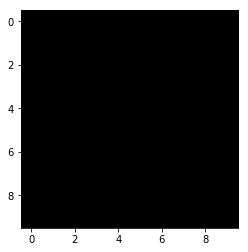

In [56]:
train_model(model, env, exp_replay, num_episodes=1000)
animation = create_animation(model, env, num_games=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises:
1. Add a validation function, to make it easier to assess models.
1. We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Change the code so that the basket is trying to avoid getting hit by the fruit.
1. Change the code so the game keeps going until the basket misses the fruit. (To test that this is working, you may want to change the number of games in the animation to 1.) How should this change the rewards that the model gets?
1. Change the game to something entirely different.
1. Try changing how the training works, using more of a policy gradient strategy.

In [7]:
a = [1,2,3]
a[1:]

[2, 3]